## Solving for the beam

This notebook is an example showing how to use the beam_solver package to construct or estimate the primary beam given a catalog of sources. 

In [2]:
%matplotlib notebook
from beam_solver.data import DATA_PATH
import beam_solver.catdata as cd
import beam_solver.beamsolve as bs
import beam_solver.beam_utils as bt
import nose.tools as nt
import numpy as np
import aipy
import os
import copy
import pylab
from collections import OrderedDict
import time
import linsolve
import healpy as hp

In [3]:
def create_catdata(azalt, data, nsrcs, npoints):
    catd = cd.catData()
    catd.azalt_array = azalt
    catd.data_array = data
    catd.Nfits = npoints
    catd.Nsrcs = nsrcs
    return catd

def gen_catdata_grid(npix, fluxvals, sigma_x, sigma_y=None):
    if sigma_y is None: sigma_y = sigma_x
    tx, ty, tz = bt.get_top(npix, center=(npix/2, npix/2), res=1)
    azs, alts = aipy.coord.top2azalt(np.array([tx, ty, tz]))
    data_arr = np.zeros((1, npix, npix))
    for ii in xrange(npix):
        data_arr[0, ii, :] = bt.get_src_tracks(np.array([tx[ii,: ], ty[ii, :], tz[ii, :]]), fluxvals[ii], sigma_x=sigma_x, sigma_y=sigma_y)
    catd = create_catdata(np.array([azs, alts]), data_arr, npix, npix)
    return catd

In [5]:
fluxvals = np.random.random(50) + 10
catd = gen_catdata_grid(50, fluxvals, sigma_x=0.4, sigma_y=0.2)
bms = bs.BeamOnly(cat=catd, bm_pix=31)
bms.add_eqs(catalog_flux=fluxvals)
sol = bms.solve()
obsbeam = bms.eval_sol(sol)

Solving 0/1


<IPython.core.display.Javascript object>


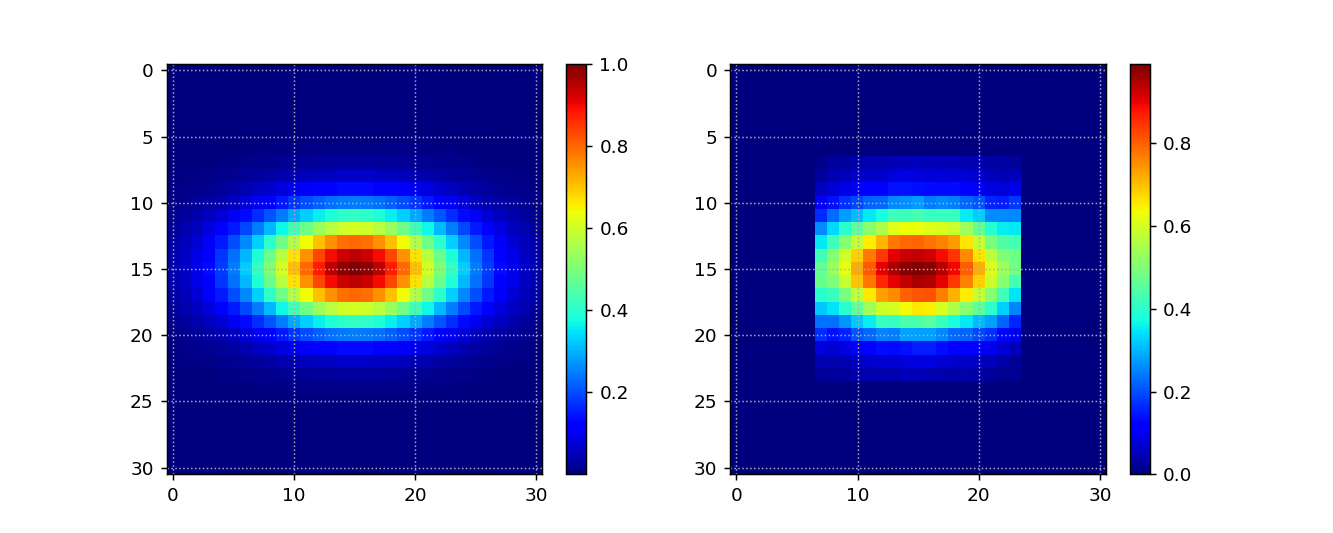

In [21]:
# generating gaussian beam
gaussbeam = bt.get_gaussbeam(sigma_x=3,sigma_y=6, mu_x=15, mu_y=15, size=31)

fig = pylab.figure(figsize=(10, 4))
pylab.subplot(121)
pylab.imshow(gaussbeam, aspect='auto', cmap='jet')
pylab.colorbar()
pylab.grid(ls='dotted')

pylab.subplot(122)
pylab.imshow(obsbeam.T, aspect='auto', cmap='jet')
pylab.colorbar()
pylab.grid(ls='dotted')

Assuming that the beam in both polarization direction (i.e aalong x and y axis) is a 90 degree rotation of each other we use this property to solve for the beam.

In [31]:
newdata = np.zeros((2, 50, 50))
newdata[:, :, :] = catd.data_array[0, :, :]
catd.data_array = newdata
catd.Npols = 2
bms = bs.BeamOnlyCross(cat=catd, bm_pix=31)
bms.add_eqs(catalog_flux_xx=fluxvals, catalog_flux_yy=fluxvals, theta_xx=[0], theta_yy=[np.pi/2], flip_yy=[-1])
sol = bms.solve()
obsbeam = bms.eval_sol(sol)
gaussbeam = bt.get_gaussbeam(5, mu_x=15, mu_y=15, size=31)

Solving 0/1


<IPython.core.display.Javascript object>


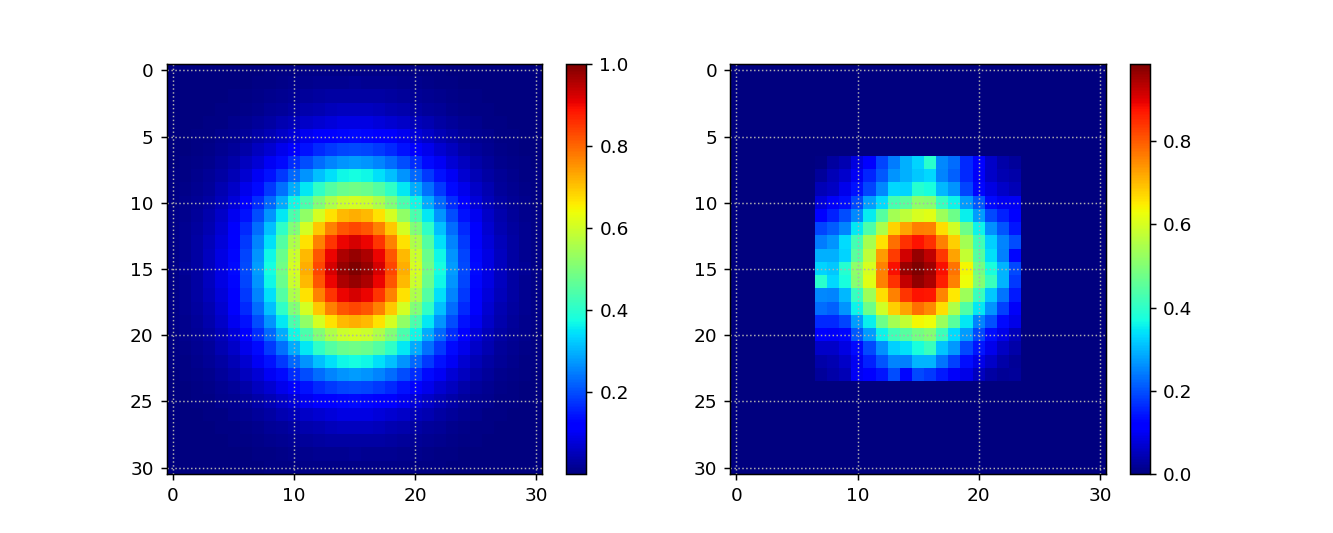

In [30]:
fig = pylab.figure(figsize=(10, 4))
pylab.subplot(121)
pylab.imshow(np.rot90(gaussbeam), aspect='auto', cmap='jet')
pylab.colorbar()
pylab.grid(ls='dotted')

pylab.subplot(122)
pylab.imshow(obsbeam.T, aspect='auto', cmap='jet')
pylab.colorbar()
pylab.grid(ls='dotted')